In [1]:
# %load ./pre_process.py
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import model_selection

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from time import perf_counter

from pycm import ConfusionMatrix, Compare

import re


def experiment(model, X, Y, alg_title, files, report = True, n = 1):
    
    x = []
    f = []
    e = []
    t = []
    p = []
    
    for i in range(n):
        t_start = perf_counter()

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

        model.fit(X_train, Y_train)

        Y_pred = model.predict(X_test)

        t_stop = perf_counter()

        elapsed_time = t_stop - t_start

        cm = ConfusionMatrix(actual_vector = Y_test, predict_vector = Y_pred)
        
        x.append(alg_title)
        f.append(files)
        e.append(elapsed_time)
        t.append(Y_test)
        p.append(Y_pred)
        
    sq = { 'alg': x, 'file': f, 'elapsed_time': e, 'test': t, 'pred': p }
    df = pd.DataFrame(sq)
    file_name = re.sub('[\s+]', '', files + '_' + alg_title + '_cm.csv')
    df.to_csv(file_name, index = False)

    if report and n == 1:
        print(alg_title)
        print(classification_report(Y_test, Y_pred))

        cm.plot(cmap = plt.cm.Greens, number_label = True, title = alg_title, plot_lib = 'matplotlib')
        file_name = re.sub('[\s+]', '', files + '_' + alg_title + '_cm.png')
        plt.savefig(file_name)
        plt.show()
    
    if n == 1:
        return {
            'elapsed_time': elapsed_time,
            'test': Y_test,
            'pred': Y_pred,
            'cm': cm,
            'title': alg_title,
        }

def run_pre_process(data):
    
    data.drop(data.columns.difference(['n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'lOCode', 'lOComment', 'lOBlank', 'uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'defects']), 1, inplace=True)

    data.groupby('defects')['b'].apply(lambda x: x.count())

    sns.histplot(data = data, x = 'defects')
    plt.tight_layout()
    plt.show()
    
    data.corr()

    f, ax = plt.subplots(figsize = (15, 15))
    sns.heatmap(data.corr(), annot = True, linewidths = .5, fmt = '.2f')
    plt.show()

    sns.scatterplot(data = data, x = 'v', y = 'b')
    plt.show()

    sns.boxplot(data = data, x = 'uniq_Op')
    plt.show()

    from sklearn import preprocessing

    scale_v = data[['v']]
    scale_b = data[['b']]

    minmax_scaler = preprocessing.MinMaxScaler()

    v_scaled = minmax_scaler.fit_transform(scale_v)
    b_scaled = minmax_scaler.fit_transform(scale_b)

    data['v_ScaledUp'] = pd.DataFrame(v_scaled)
    data['b_ScaledUp'] = pd.DataFrame(b_scaled)

    data

    X = data.iloc[:, :-10].values
    Y = data.defects.values

    validation_size = 0.20
    seed = 7
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size = validation_size, random_state = seed)

    return X, Y, X_train, Y_train, seed

def result_analysis(results, files):

    elapsed_times = [ t['elapsed_time'] for t in results ]
    labels = [ l['title'] for l in results ]

    x = np.arange(len(elapsed_times))
    width = .35
    fig, ax = plt.subplots()
    rects_elapsed_times = ax.barh(x, elapsed_times, width, label='Tempos de execução (em segs)')
    ax.set_xlabel('Tempos')
    ax.set_title('Tempos por algorítimo')
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend()
    fig.tight_layout()
    file_name = re.sub('[\s+]', '', files + '_elapsed_times.png')
    plt.savefig(file_name)
    plt.show()

    experiments = { e['title']: e['cm'] for e in results }

    print(Compare(experiments))

    for e in results:
        print(e['title'],'MCC:',e['cm'].MCC,'ACC:',e['cm'].ACC)

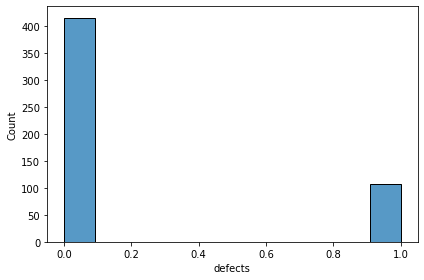

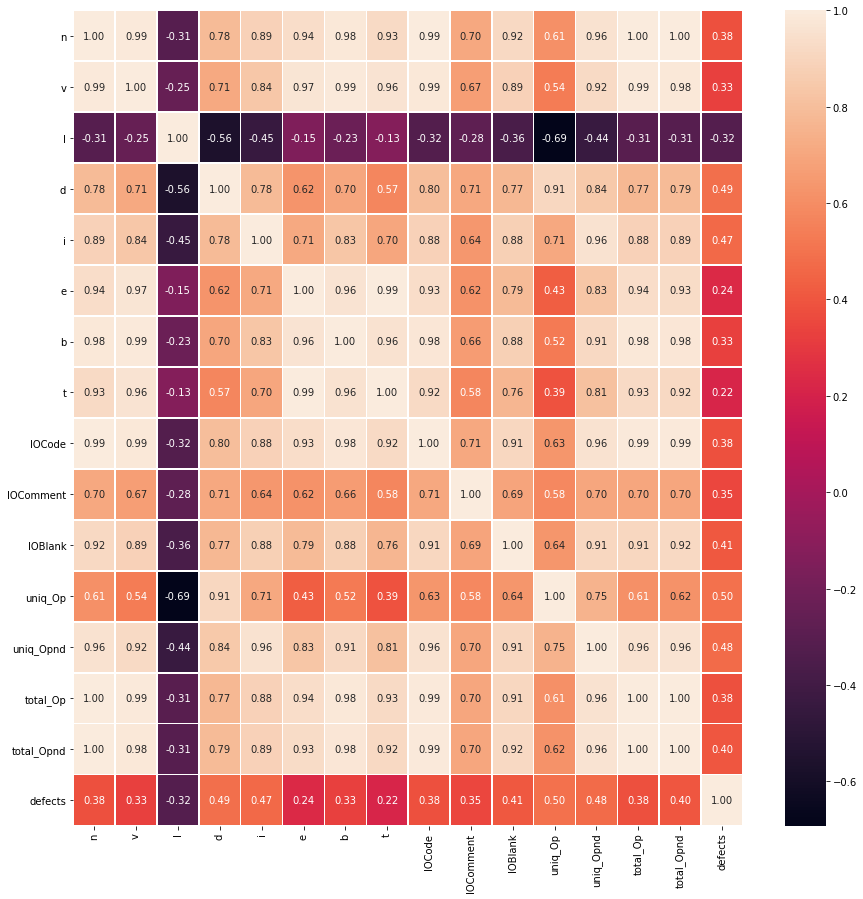

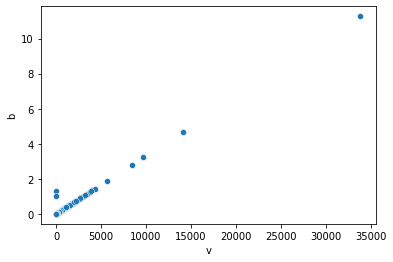

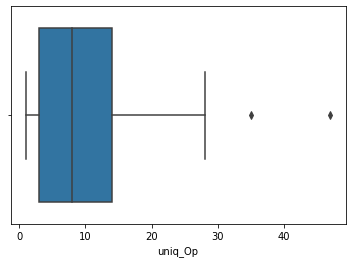

In [2]:
data = pd.read_csv('../_data/kc2.csv')
X, Y, X_train, Y_train, seed = run_pre_process(data)

In [4]:
# results = [0] * 4

# Decision Tree

In [5]:
# model = tree.DecisionTreeClassifier()

In [6]:
# results[0] = experiment(model, X, Y, 'Decision Tree', files = 'KC2')

# Naïve Bayes

In [7]:
# model = GaussianNB()

# scoring = 'accuracy'
# kfold = model_selection.KFold(n_splits = 10, random_state = seed, shuffle = True)
# cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
# print("Mean : %f - Std : (%f)" % (cv_results.mean(), cv_results.std()))

In [8]:
# results[1] = experiment(model, X, Y, 'Naïve Bayes', files = 'KC2')

# Random Forest

In [9]:
# model = RandomForestClassifier(n_estimators = 100)

In [9]:
# results[2] = experiment(model, X, Y, 'Random Forest', files = 'KC2')

# Support Vector Machine

In [11]:
# model = svm.SVC(kernel = 'linear', C = 0.01)

In [10]:
# results[3] = experiment(model, X, Y, 'Support Vector Machine', files = 'KC2')

# Análise de Resultados

In [11]:
# result_analysis(results, files = 'KC2')

In [3]:
model = tree.DecisionTreeClassifier()
experiment(model, X, Y, 'Decision Tree', files = 'KC2', report = False, n = 100)

model = GaussianNB()
scoring = 'accuracy'
kfold = model_selection.KFold(n_splits = 10, random_state = seed, shuffle = True)
cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
print("Mean : %f - Std : (%f)" % (cv_results.mean(), cv_results.std()))
experiment(model, X, Y, 'Naïve Bayes', files = 'KC2', report = False, n = 100)

model = RandomForestClassifier(n_estimators = 100)
experiment(model, X, Y, 'Random Forest', files = 'KC2', report = False, n = 100)

Mean : 0.848955 - Std : (0.042775)


> This is the end